# Electromagnetic wave absorption by a plasma ramp
## Simulation

In [15]:
import sys
sys.path.insert(1, '../../python')
sys.path.insert(2, '../nb_hlpr')
import em1d
import numpy as np
dt=0.028
tmax=170.

nx=8000
box=225

ndump=25
# Background plasma

ppc = 2 # Particles per cell
#vth=[0.0,0.02,0.02]


density = em1d.Density( type = "ramp", start = 180, end = 305, ramp = [0,150.0] )

electrons = em1d.Species( "electrons", -1.0, ppc,density=density)


# Diagnostics
def rep( sim ):
    if ( sim.n % ndump == 0 ):
        
        # All electric field components
        sim.emf.report( "E", 2 )
        
        # Charge density
        electrons.report( "charge",quants=None,pha_nx=None,pha_range=None )
        # x1u1 phasespace
        # electrons.report( em1d.phasespace( em1d.SpeciesDiag.x1, em1d.SpeciesDiag.u1),
        #                  pha_nx = [1024,512], pha_range = [[0.0,20.0],[-2.0,2.0]])

# Initialize simulation data
sim = em1d.Simulation( nx, box, dt, species=electrons, report = rep )

# Add laser pulse
sim.add_laser( em1d.Laser( start = 175.0, fall = 5.0,flat=145,rise=25, a0 = 0.000001, omega0 = 6.0, polarization = np.pi/2 ))


# Select open boundary conditions
sim.emf.bc_type = "open"

In [16]:
# Run the simulation
sim.run( tmax )


Running simulation up to t = 170 ...
n = 6072, t = 170.016
Done.


## Result analyser

To Plot ZDF data files you must first import the ZDF module

In [2]:
import numpy as np
import widg
from IPython.display import HTML

First you need to select the data files that correspond to your simulation using the file chooser below.
<br> You may also specify the data type (*e.g* "charge")

You can also choose to plot a single quantity or two at the same time on the "Settings" tab.



In [3]:
tab=widg.tabmaker()
tab

### Visualization

Here you can use the slider to advance or go backwards in time

In [17]:
ylims=[[0,0],[0,0]]
fils=[]

widg.shower(tab,ylims,fils)[0]

interactive(children=(IntSlider(value=0, description='Iteration: ', max=6050, step=25), FloatRangeSlider(value…

<function visual.pltinteract.<locals>.pltstf(itr, fil, col, fil2=[], col2=None, xlims=None, ylims=None, fils=[], plasm=False)>

# Comparison with expected results

The theory behind elctromagnetic wave absorption by a plasma tells us that the <br>
the wave can penetrate the plasma up until a given length which depends btoh <br>
on the frequency of the wave and the plasma density. This length is called the<br>
penetration length:<br>

$\large{\delta=\frac{c}{\sqrt{\omega_{pe}^2-\omega^2}}}=\frac{1}{k}$

this happens only if the wave's frequency is smaller than the plasma frequency, $\omega_{pe}$, <br>
if on the other hand, the wave's frequency is larger than the plasma frequency, the <br> wave is
able to propagate normally.

Therefore, if the the plasma density is not constant (*e.g* increasing density) the <br>
wave may propagate normally up until a certain point and then start  decaying, <br> as shown in
the next figure:

<img src="ex.png"  style="width: 50%; float: left;" />

The shape of the wave function is described by the Airy function, given by:

$ Ai(z)={\large \frac{1}{\pi}}{\large\int_0^\infty}\cos{\left({\large \frac{t^3}{3}}-z t\right)}dt $

where $z=\left({\large \frac{\omega}{c\sqrt{L}}}\right)^{2/3}(x-L)=\beta^{2/3}(x-L)$ for a collionless plasma with density $n(x)=n_c\large\frac{x}{L}$. <br>Where $L$ is the distance form the beginniig of the plasma until the critical density point

\*$n_c$ is the critical density for the wave frequency $\omega$, *i.e.*, the densty for which <br> the wave no longer propagates and starts to be absorbed

The Airy Function can be approximated by more treatable functions like <br>
cosines (for the left part) and exponentials (for the right part), however, the <br> transition 
region is poorly approximated by any of these functions as you can see below:
<img src="Mplwp_airyai_asymptotic.svg"  style="width: 50%; float: left;" />

You can find out more about the Airy Function on its wikipedia page 
(https://en.wikipedia.org/wiki/Airy_function) <br>
but for now all you need to know is that the approxiamtion  goes as follows: <br>

$ Ai(z)\simeq{\large \frac{1}{\pi^{1/2}(-z)^{1/4}}}\cos{\left({{\large\frac{2}{3}}(-z)^{3/2}}-{\large\frac{\pi}{4}}\right)}dt, \;\;\text{for}\;z\ll -1$ 


$ Ai(z)\simeq{\large \frac{1}{\pi^{1/2}(z)^{1/4}}}\exp{\left({{\large-\frac{2}{3}}(z)^{3/2}}\right)}dt, \;\;\text{for}\;z\gg 1$ 


The function is defined below:

In [5]:
def Emfun(x, beta, L,E0):
    y=np.zeros(len(x))
    for i, xi in enumerate(x): 
        if xi <= L:
            y[i] =  E0/(np.sqrt(np.pi*np.sqrt(-beta*(xi-L))))*np.cos(2/3*(-beta*(xi-L))**1.5-np.pi/4)
        elif xi >= L:
            y[i] = E0*0.5/np.sqrt(np.pi*np.sqrt(beta*(xi-L)))*np.exp(-2/3*(beta*(xi-L))**1.5)  
    return y

In order to verify this theory, you can either fit your simulation results to the Airy function, <br>
or directly compare to the expected results using the parameters that you defined on the inputdeck.

## Fit

Start by choosing an apropriate instant on your simulation (after the stationary regime has been established) <br>
using the first slider above. 

After that you must identify the region where the aproximations don't hold using the following tool


In [6]:
import ramp

file2=fils[0]
file1=fils[1]

datavec=[]

ramp.intregsel(file1,file2,datavec)

interactive(children=(FloatSlider(value=202.5393799224903, description='x-axis limit:', max=225.0, min=180.078…

<function ramp.regselect(maxx, itr, w, file1, file2, datav, sldr)>

In [7]:
ret=ramp.paramaker()
param=ret[1]
display(ret[0])

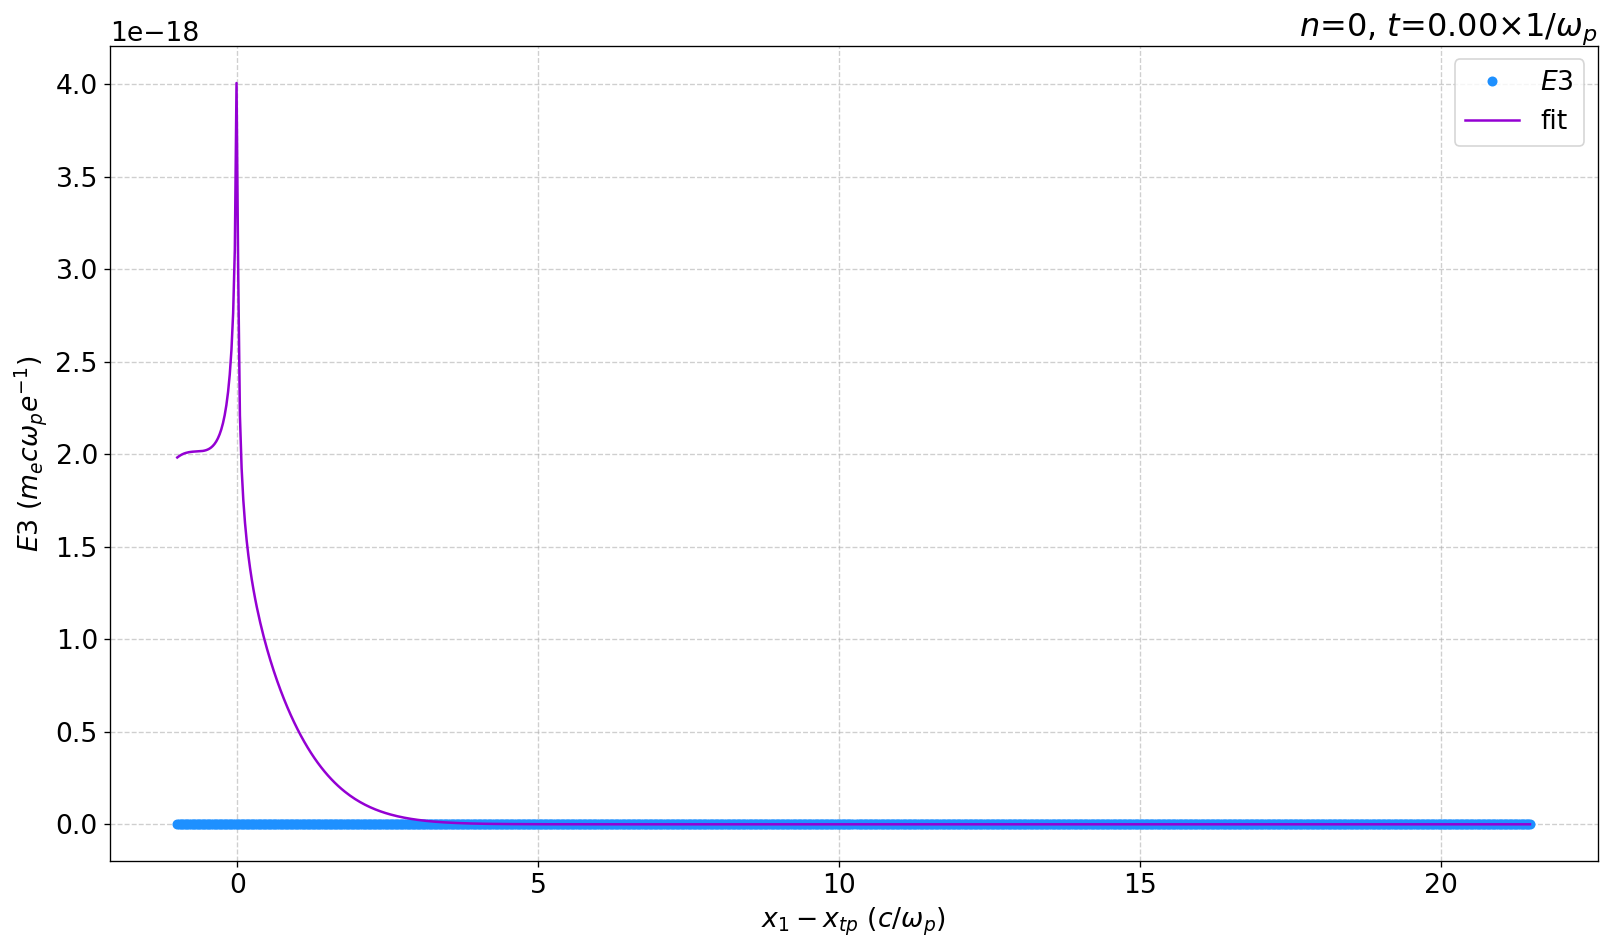

In [8]:
ramp.fiter(datavec,param,Emfun)    

In [37]:
print((1.064596464385103**1.5)*(29.95084566890867**0.5))
print(((1.064596464385103**1.5)*(29.95084566890867**0.5))**2/29.95084566890867)

6.01148923748056
1.2065770446628385


## Direct comparison

Once again, start by choosing an apropriate instant on your simulation (after the stationary regime has been established) <br>
using the first slider above. 

In [9]:
dcomp=ramp.dircompars()
dparam=dcomp[1]
display(dcomp[0])

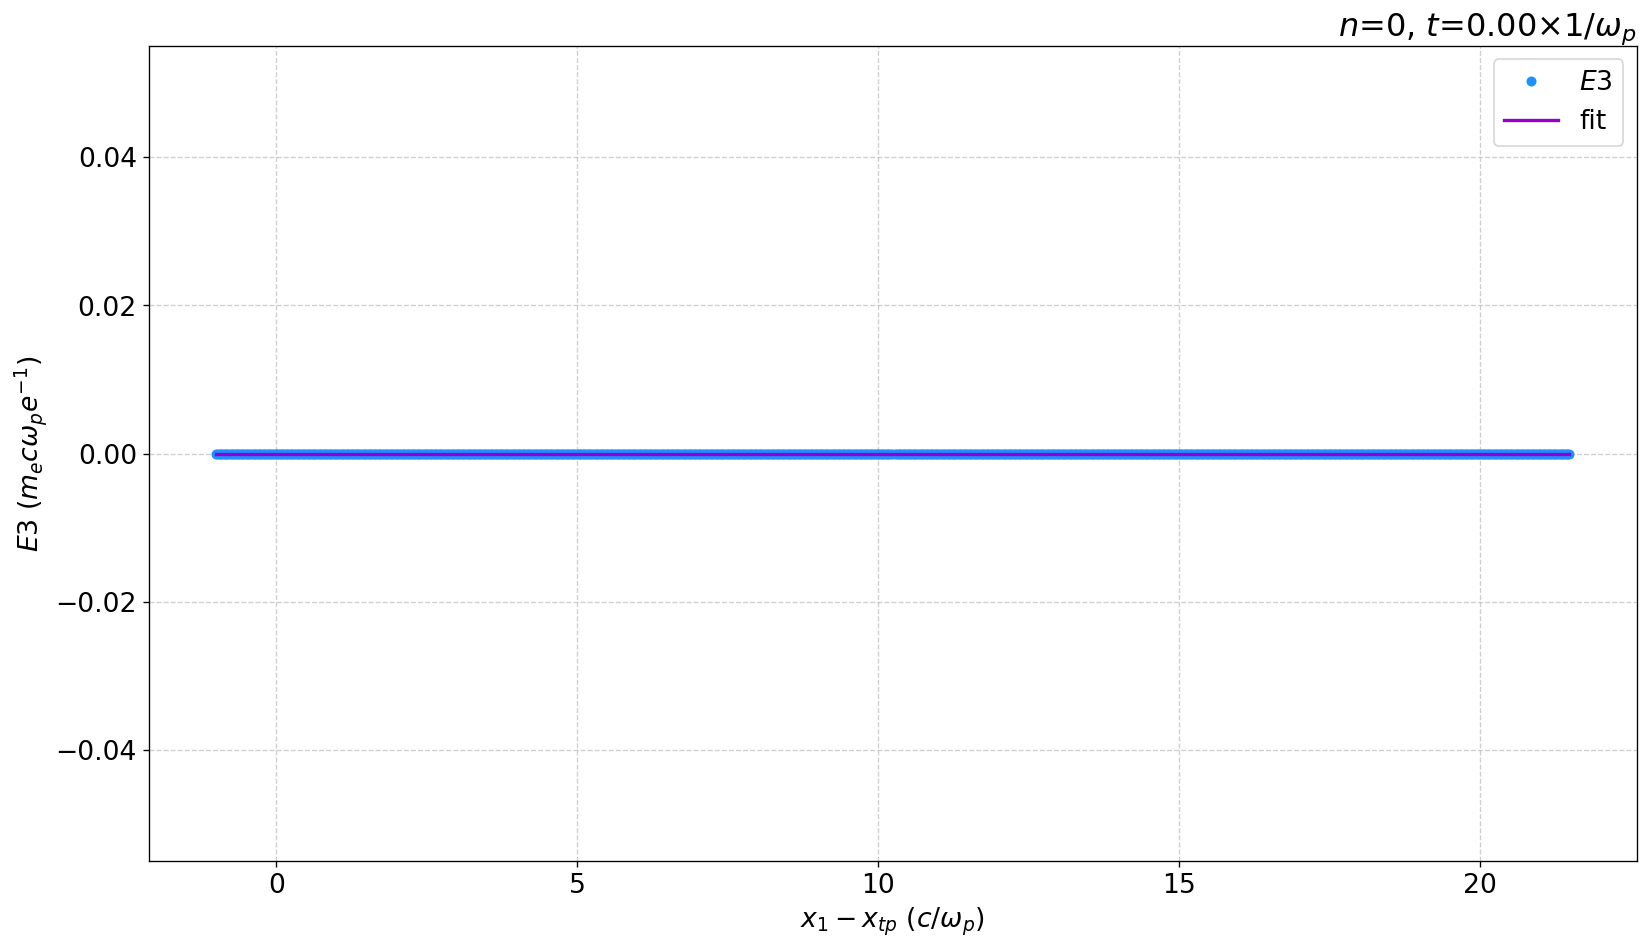

In [10]:
ramp.dircomp(datavec,dparam,Emfun,save=True)

# VIDEO OUTPUT

You may also produce a video

/home/pardalio/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


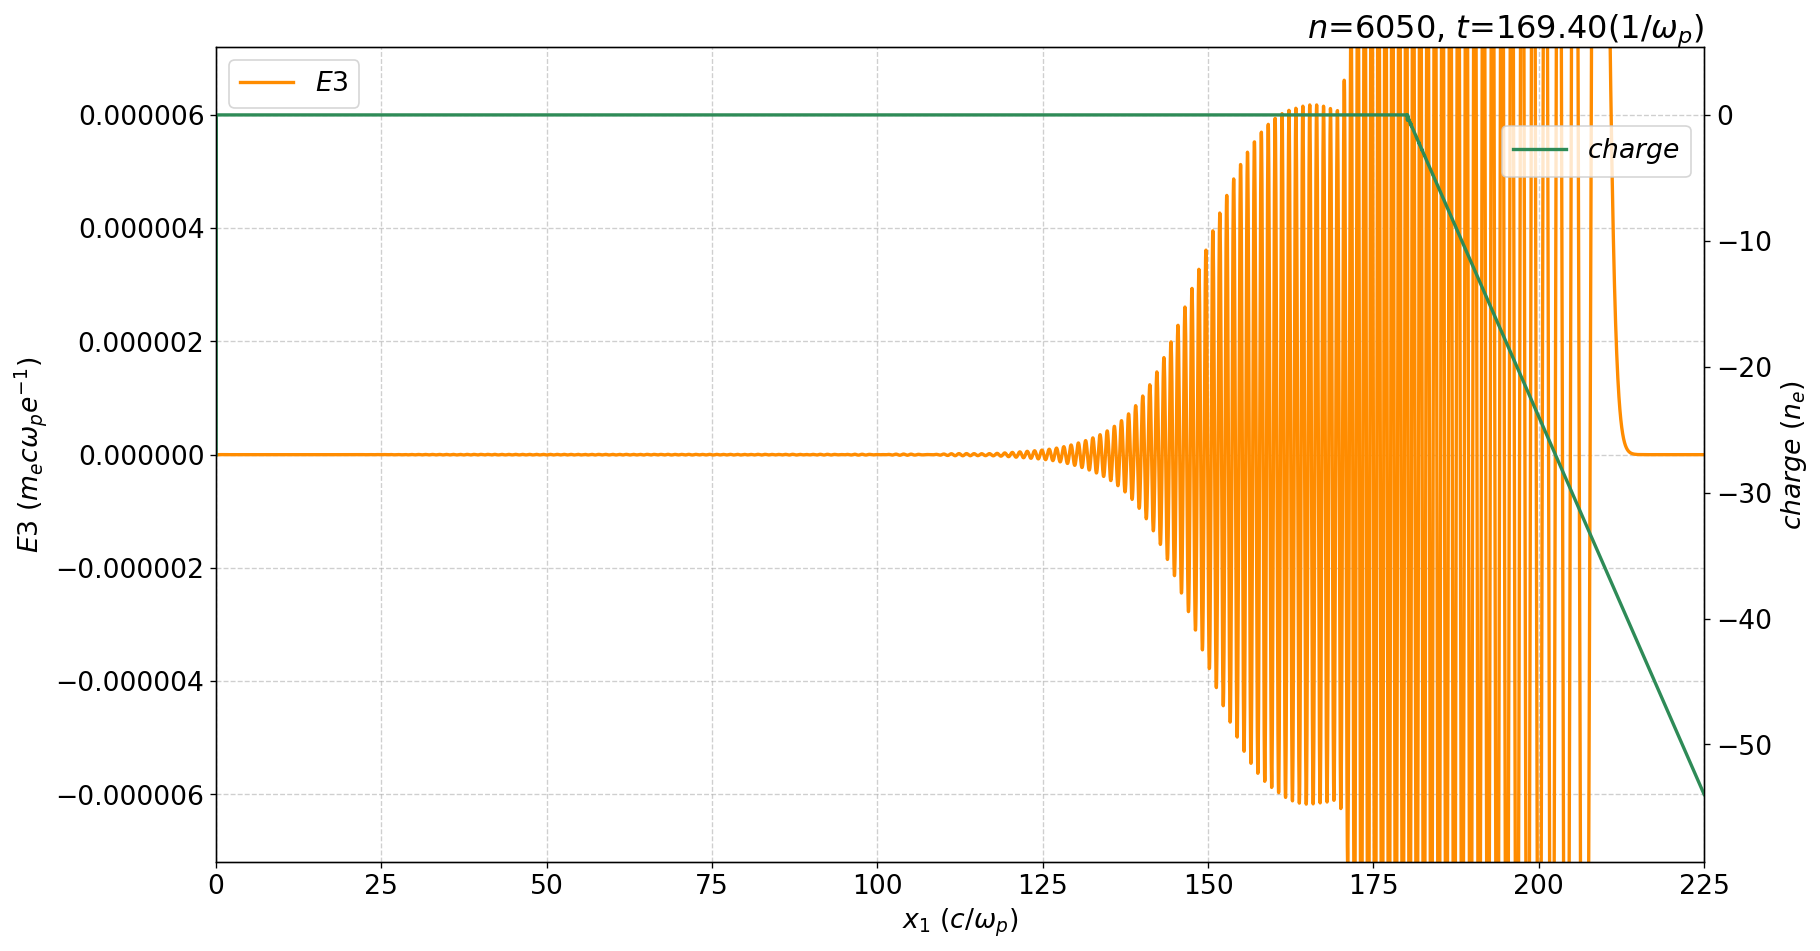

In [12]:
import visual
anim=visual.animate(tab,ylims)
HTML(anim.to_html5_video())

And save it using a name of your choice, choose wisely as it can't be changed later

In [31]:
anim.save("aa9.mp4",fps=20)